Appropriate feature engineering and feature selection goes a long way towards ensuring the performance of machine learning algorithms one is building. This notebook consolidates some of the methods encountered thus far over the course of one and a half years.

### Content
* [1. ](#1): Dataset & Approach
* [2. ](#2): EDA
* [3. ](#3): Baseline
* [4. ](#4): Feature Selection - select by statistical testing
* [5. ](#5): Feature Selection - eliminate Low variance features
* [6. ](#6): Recursive Feature Elimination
* [7. ](#7): Recursive Feature Elimination with Cross Validation
* [8. ](#8): Mutual Information
* [9. ](#9): Regularized Regression
* [10. ](#10): Variance Inflation Factor & Interaction Term(s)

<a id='1'></a>
### Dataset
The dataset used is sourced from Kaggle, ["Basic Computer Data"](https://www.kaggle.com/kingburrito666/basic-computer-data-set?select=Computers.csv) by Liam Larsen. 

### Approach
We'll conduct EDA on the dataset to gain a better undertsanding of the dataset, data cleaning if needed. Then we'll establish a baseline and go through the feature selection methods, and compare the performance against the baseline.

#### Import libraries & Config setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, ElasticNet, 
                                  RidgeCV, LassoCV, ElasticNetCV)
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
pd.set_option("display.max_columns", None)
plt.style.use('default')
plt.style.use('fivethirtyeight')
plt.rc('figure', autolayout=True, figsize=(14,4), titlesize=16, titleweight='bold')
plt.rc('axes', titlesize=16, titleweight='bold', titlepad=10, labelsize=14, labelweight='bold')
plt.rc('ytick', labelsize=12)
plt.rc('xtick', labelsize=12)

#### Load the dataset

In [3]:
df = pd.read_csv('data/Computers.csv', index_col=0)
df.head()

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
1,1499,25,80,4,14,no,no,yes,94,1
2,1795,33,85,2,14,no,no,yes,94,1
3,1595,25,170,4,15,no,no,yes,94,1
4,1849,25,170,8,14,no,no,no,94,1
5,3295,33,340,16,14,no,no,yes,94,1


In [4]:
# check for missing values
df.isnull().sum()

price      0
speed      0
hd         0
ram        0
screen     0
cd         0
multi      0
premium    0
ads        0
trend      0
dtype: int64

In [5]:
### Summary stats
df.describe(include='all')

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
count,6259.000000,6259.000000,6259.000000,6259.000000,6259.000000,6259,6259,6259,6259.000000,6259.000000
unique,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,no,no,yes,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3351,5386,5647,NaN,NaN
mean,2219.576610,52.011024,416.601694,8.286947,14.608723,NaN,NaN,NaN,221.301007,15.926985
std,580.803956,21.157735,258.548445,5.631099,0.905115,NaN,NaN,NaN,74.835284,7.873984
min,949.000000,25.000000,80.000000,2.000000,14.000000,NaN,NaN,NaN,39.000000,1.000000
25%,1794.000000,33.000000,214.000000,4.000000,14.000000,NaN,NaN,NaN,162.500000,10.000000
50%,2144.000000,50.000000,340.000000,8.000000,14.000000,NaN,NaN,NaN,246.000000,16.000000
75%,2595.000000,66.000000,528.000000,8.000000,15.000000,NaN,NaN,NaN,275.000000,21.500000


<a id='2'></a>
### EDA
#### Univariate analysis

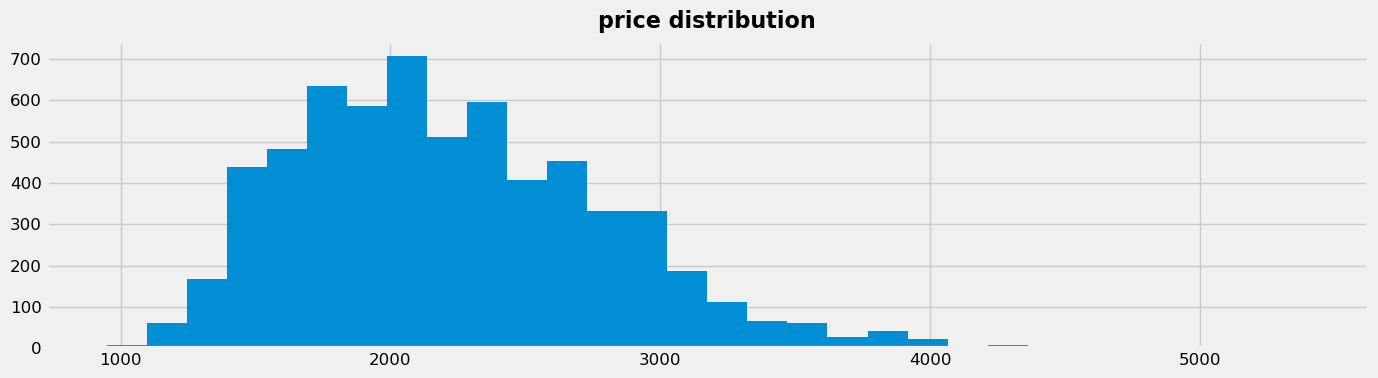

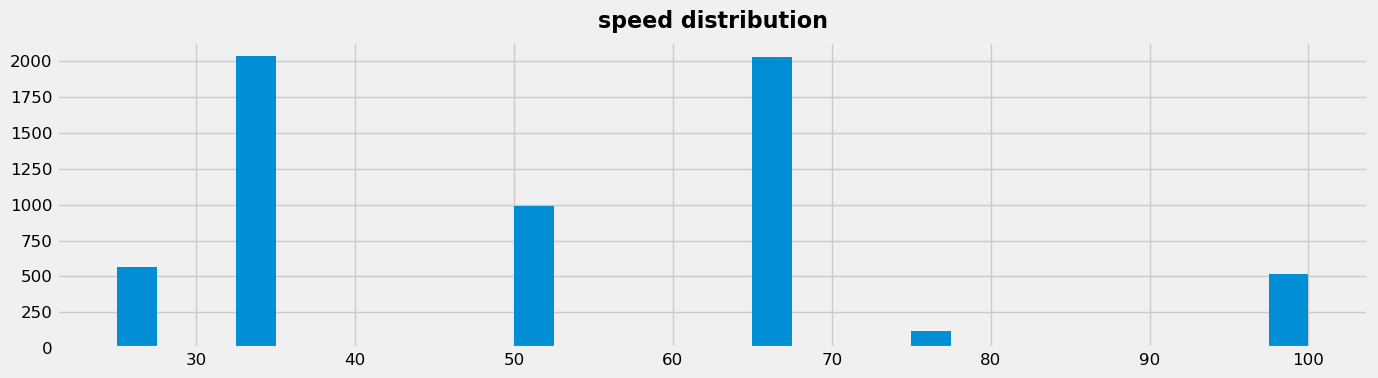

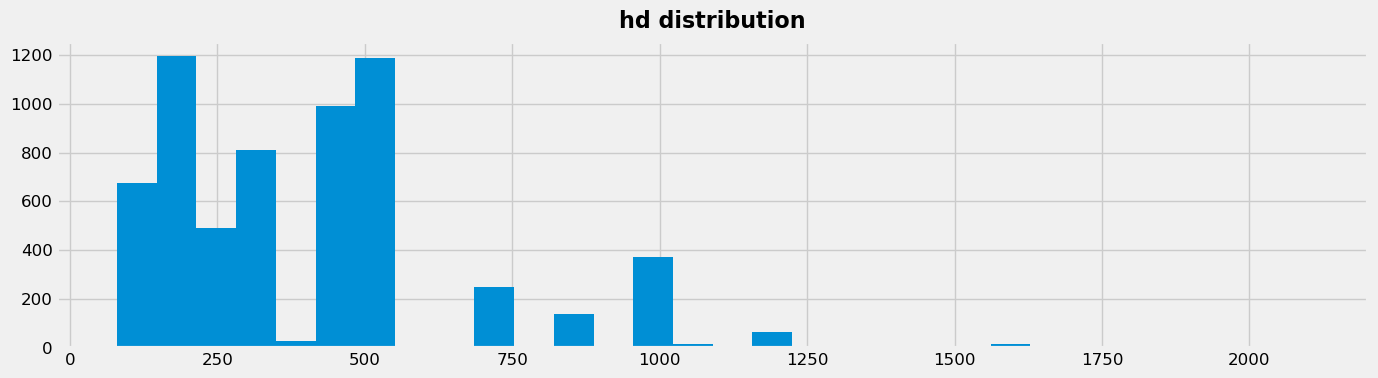

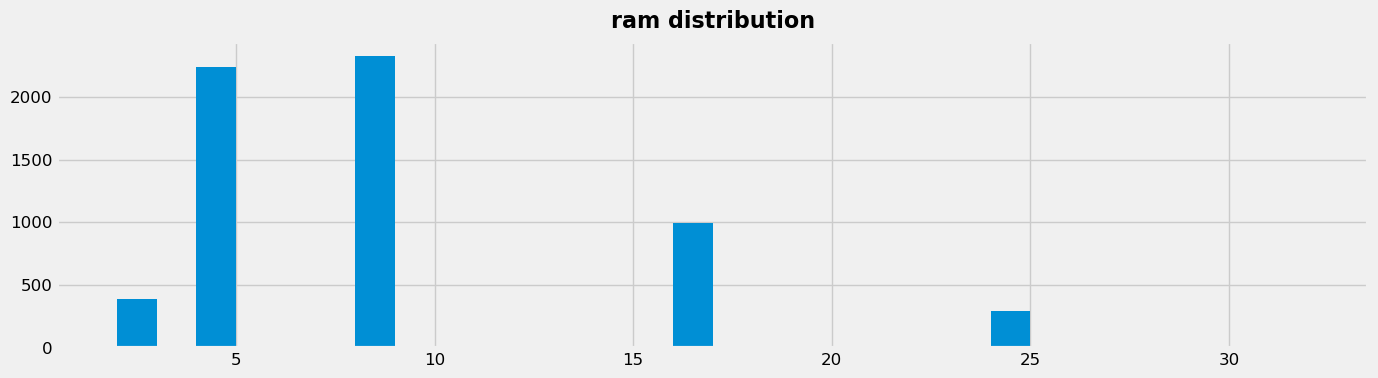

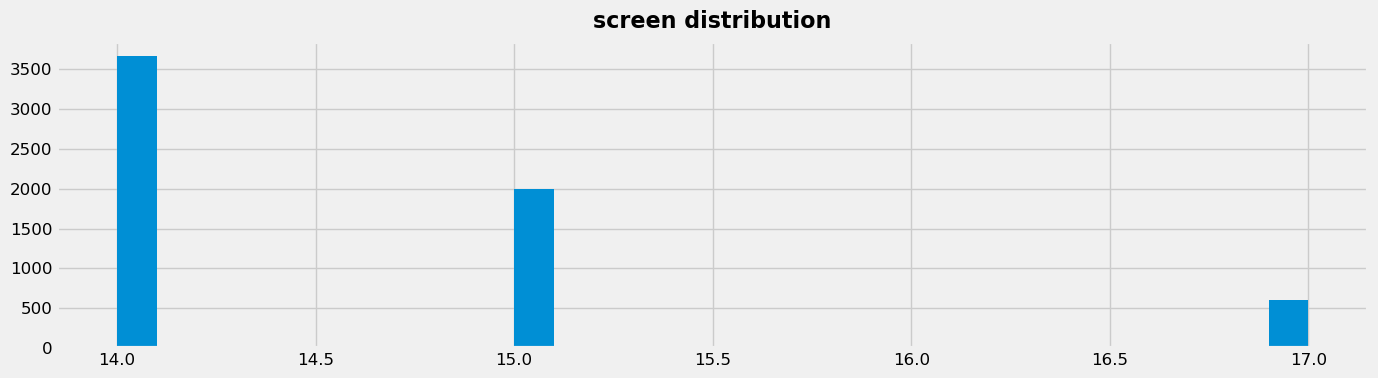

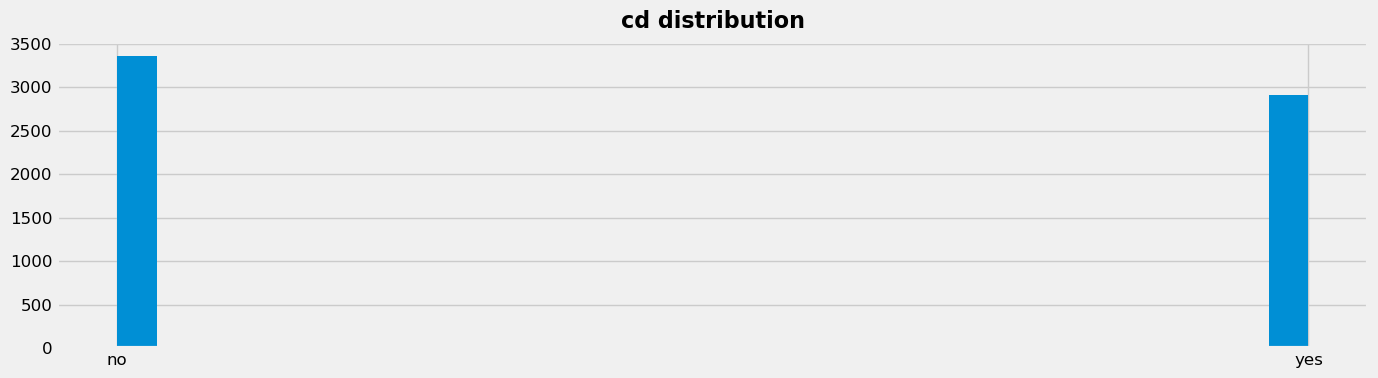

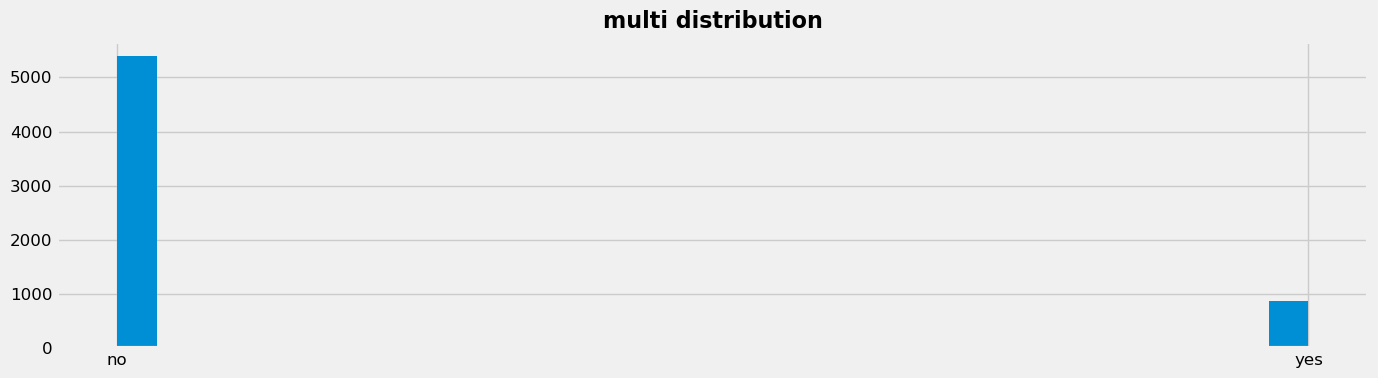

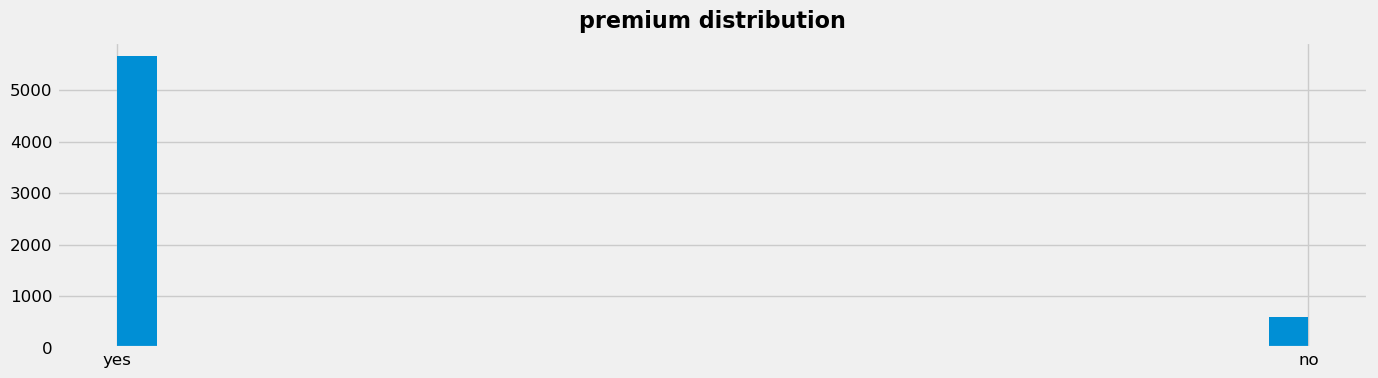

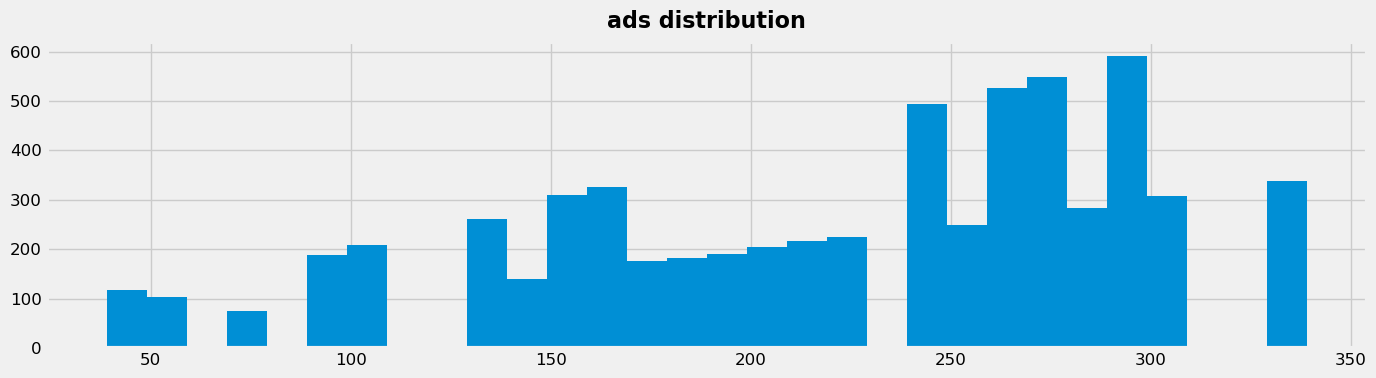

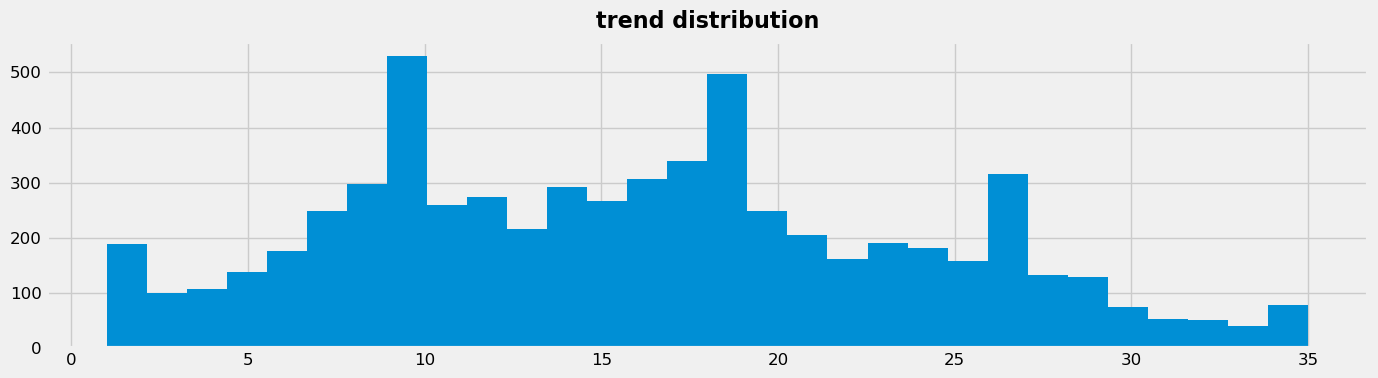

In [6]:
for col in df.columns:
    df[col].hist(bins=30)
    plt.title(f'{col} distribution')
    plt.show()

#### Bi-variante analysis
It appears that the independent variables are categorical in nature

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6259 entries, 1 to 6259
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   price    6259 non-null   int64 
 1   speed    6259 non-null   int64 
 2   hd       6259 non-null   int64 
 3   ram      6259 non-null   int64 
 4   screen   6259 non-null   int64 
 5   cd       6259 non-null   object
 6   multi    6259 non-null   object
 7   premium  6259 non-null   object
 8   ads      6259 non-null   int64 
 9   trend    6259 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 537.9+ KB


In [8]:
# helper function for boxplots
def boxplt(col):
    sns.boxplot(x=df[col], y = df['price'], fliersize=0, linewidth=1,)
    plt.title(f'{col} vs. price')
    plt.show()

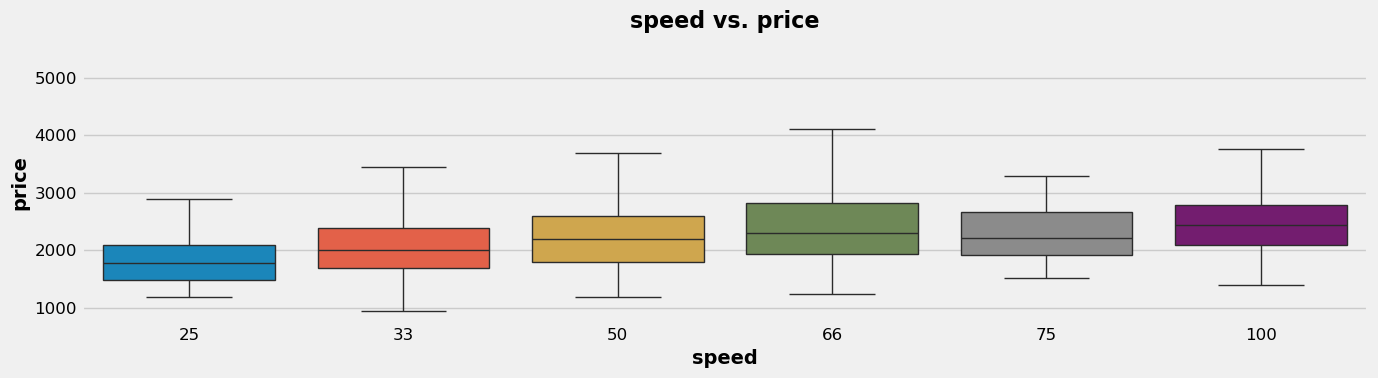

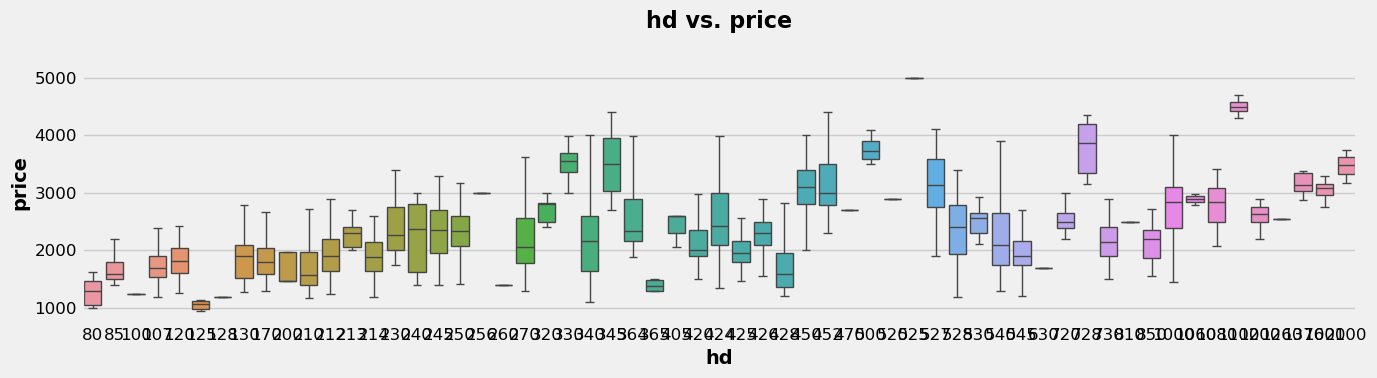

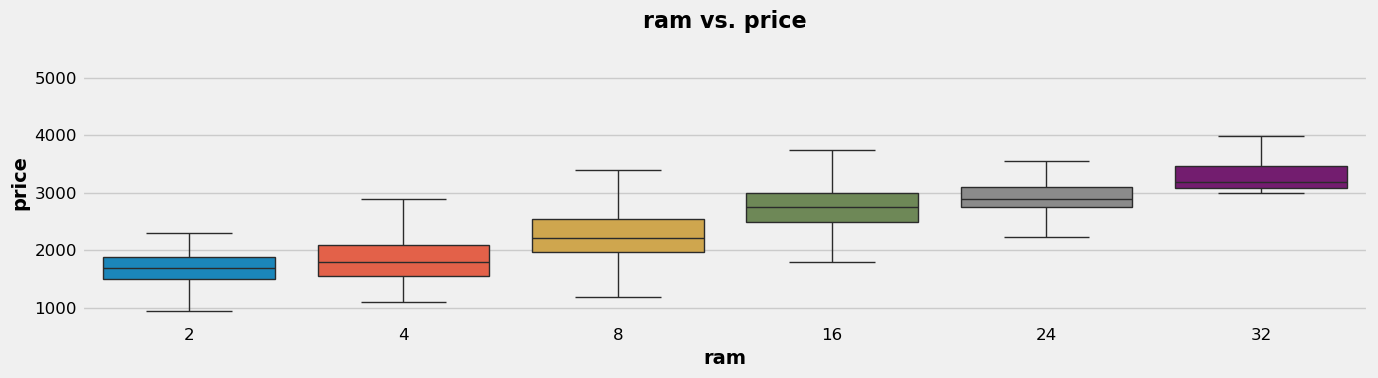

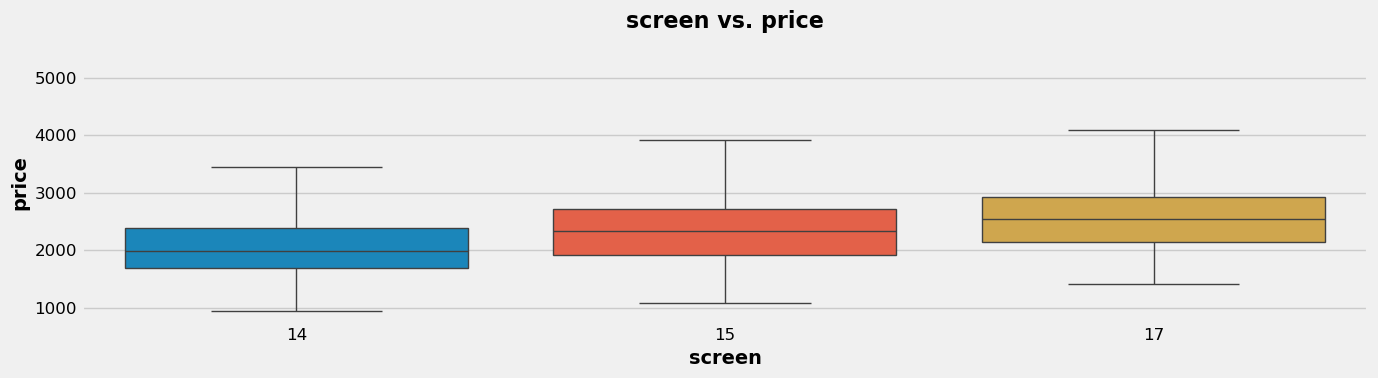

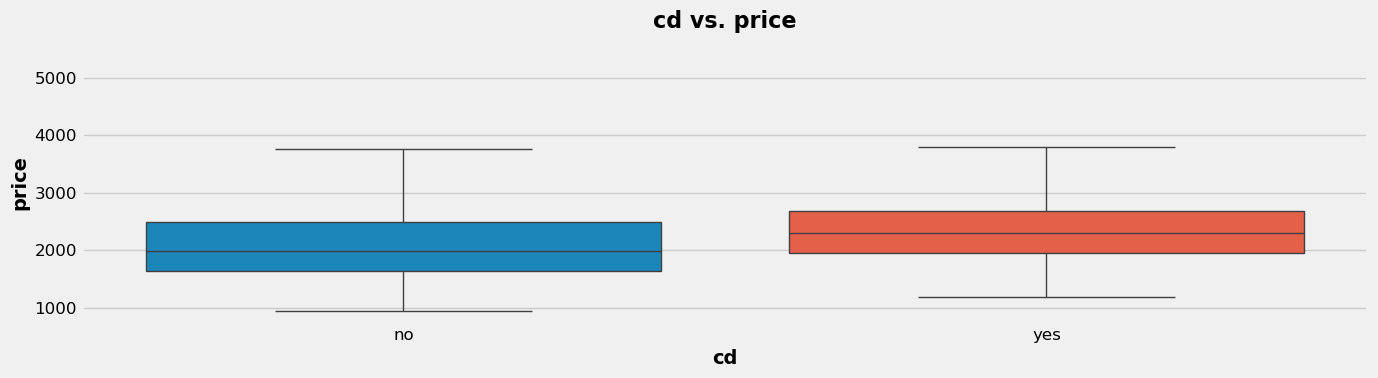

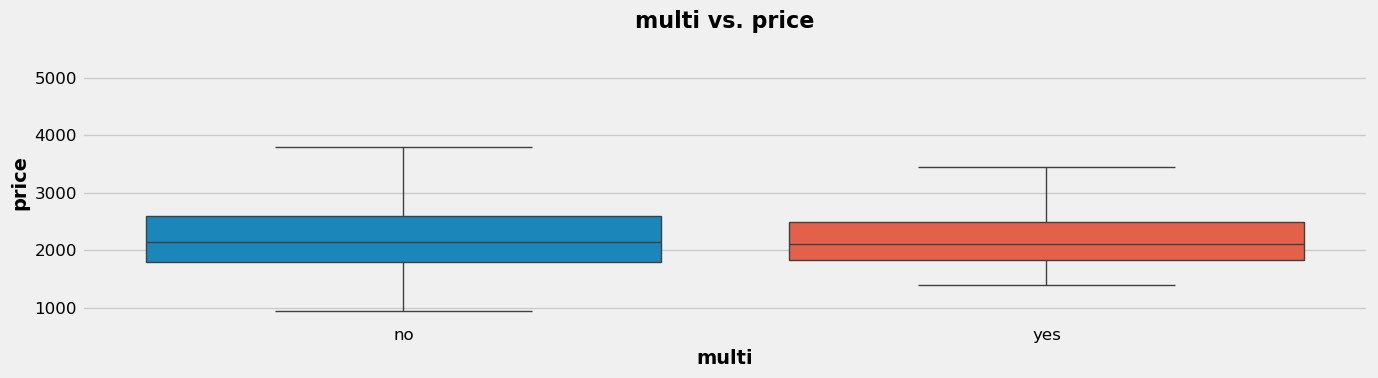

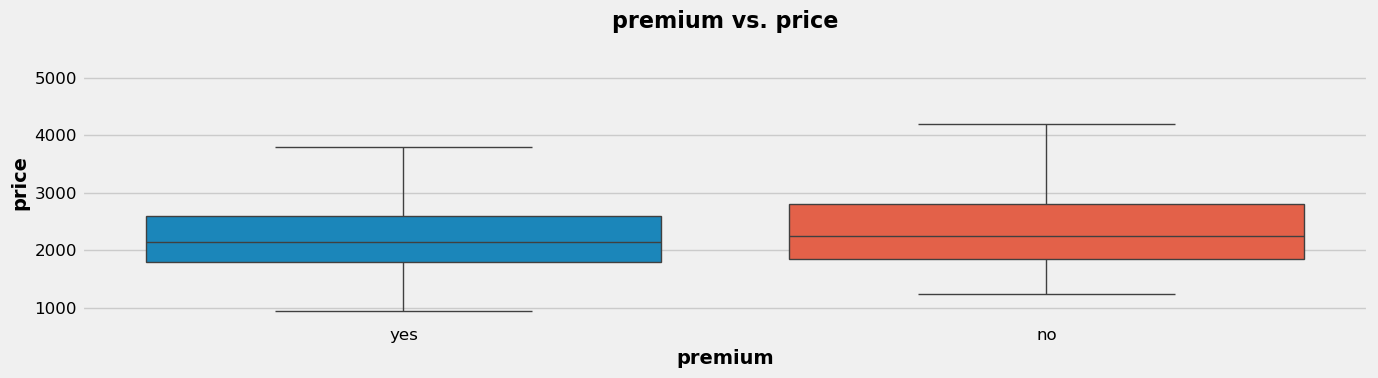

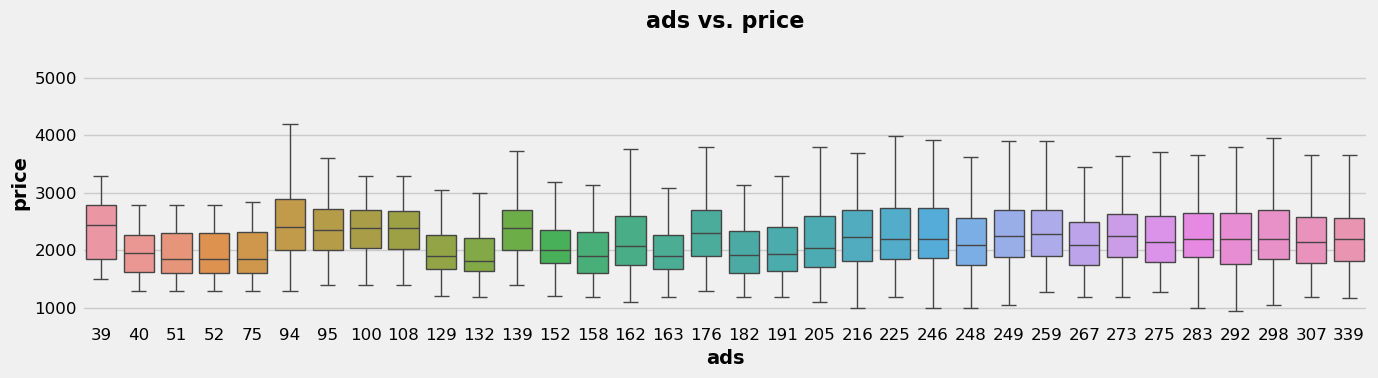

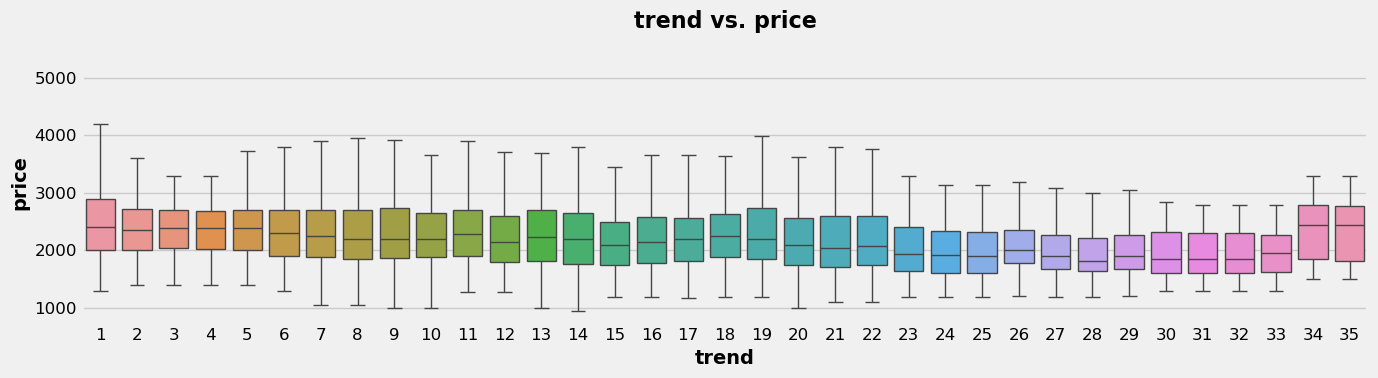

In [9]:
for col in df.iloc[:,1:].columns:
    boxplt(col)

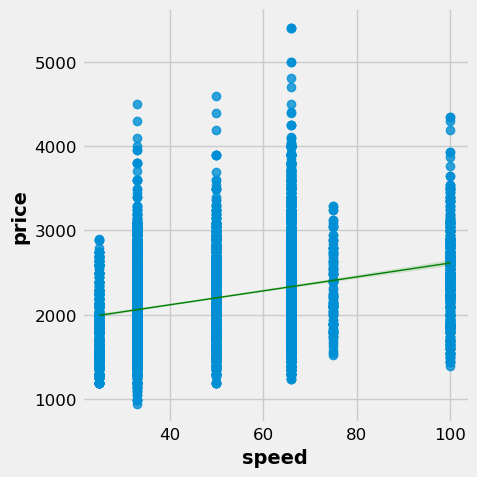

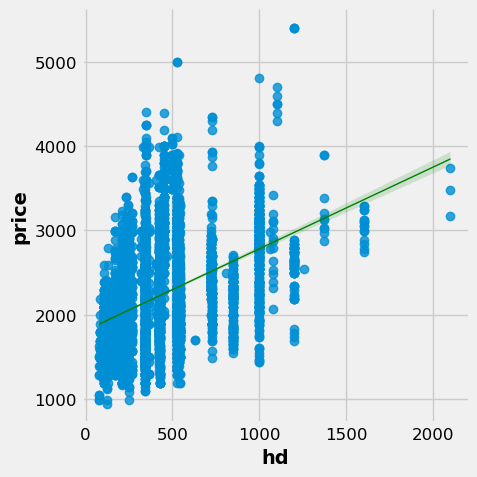

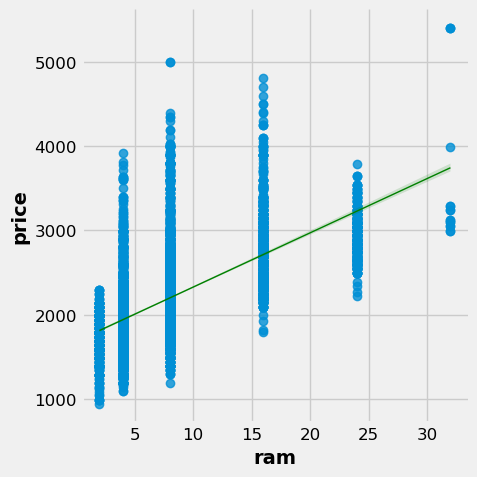

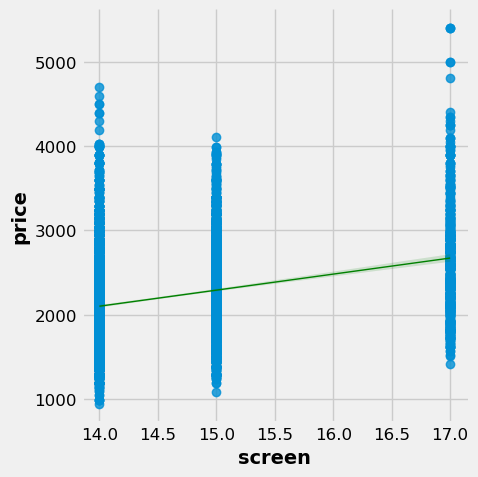

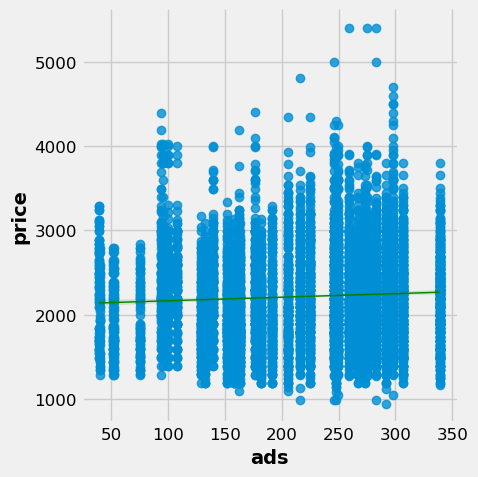

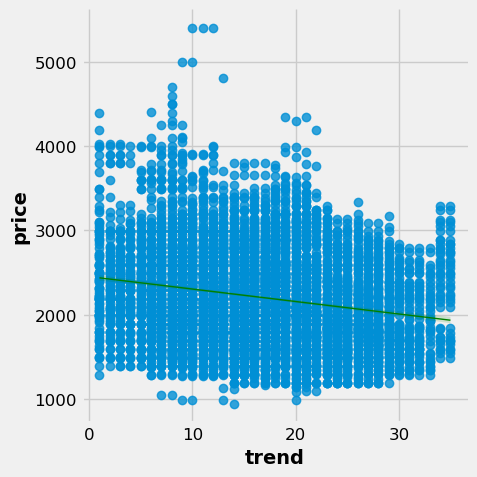

In [10]:
col_num = [col for col in df.columns if df[col].dtype != 'O']
for col in df[col_num].iloc[:,1:]:
    sns.lmplot(x=col, y='price', data=df, line_kws={"lw":1, 'color':'green'})

In [11]:
# feature engineering - (no ->0, yes -> 1)
df['cd_enc'] = [0 if x =='no' else 1 for x in df['cd'] ]
df['multi_enc'] = [0 if x =='no' else 1 for x in df['multi'] ]
df['premium_enc'] = [0 if x =='no' else 1 for x in df['premium'] ]

In [12]:
# drop cd, multi, premium
df_ = df.drop(['cd', 'multi', 'premium'], axis=1)

In [13]:
# check
df_

,price,speed,hd,ram,screen,ads,trend,cd_enc,multi_enc,premium_enc
1,1499,25,80,4,14,94,1,0,0,1
2,1795,33,85,2,14,94,1,0,0,1
3,1595,25,170,4,15,94,1,0,0,1
4,1849,25,170,8,14,94,1,0,0,0
5,3295,33,340,16,14,94,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6255,1690,100,528,8,15,39,35,0,0,1
6256,2223,66,850,16,15,39,35,1,1,1
6257,2654,100,1200,24,15,39,35,1,0,1
6258,2195,100,850,16,15,39,35,1,0,1


<a id='3'></a>
### Baseline
Build a baseline model using `ram` to predict price (pretty evident in terms of the linear relationship between `ram` and `price`). For model metric, use rmse.

* RMSE measures the standard deviation of the residuals (difference between actual and predicted values.) It is a loss function, (optimisation of model by minimizing it).

In [14]:
# Get the target and features
X = df_[['ram']]
y = df['price']

In [15]:
# 80-20 split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=0)

In [16]:
# model and evaluate
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_baseline = lr.predict(X_test)

score_baseline = mean_squared_error(y_test, pred_baseline, squared=False)
print(f'baseline rmse: {score_baseline:.2f}')

baseline rmse: 467.29


We'll build a helper function to evaluate the fitted model from here onwards.

In [17]:
def evaluateModel(iput_frame):
    X = input_frame.copy()
    y = X.pop('price')
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=0)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    score = mean_squared_error(y_test, pred, squared=False)
    print(f'model rmse: {score:.2f}')
    return score

In [18]:
# help func to collect the scores along the way
scores = []
models = []
def collectScores(input_score, model_name):
    scores.append(input_score)
    models.append(model_name)

In [19]:
# record baseline score
collectScores(score_baseline, 'baseline')

<a id='4'></a>
### Feature Selection - select by statistical testing
select useful features using statistical tests
* mannwhitneyu for independent variables with two categorical, independent groups

In [20]:
# mann-whitney u test
# cd
stats.mannwhitneyu(x=df_['cd_enc'],
                   y=df['price'])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

With a p-value 0, we can reject the null hypothesis that there is no difference in price between computers with `cd` and without `cd` .

In [21]:
# multi
stats.mannwhitneyu(x=df_['multi_enc'],
                   y=df['price'])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

With a p-value 0, we can reject the null hypothesis that there is no difference in price between computers with `multi` and without `multi`.

In [22]:
stats.mannwhitneyu(x=df_['premium_enc'],
                   y=df['price'])

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

With a p-value 0, we can reject the null hypothesis that there is no difference in price between computers with `premium` and without `premium`.

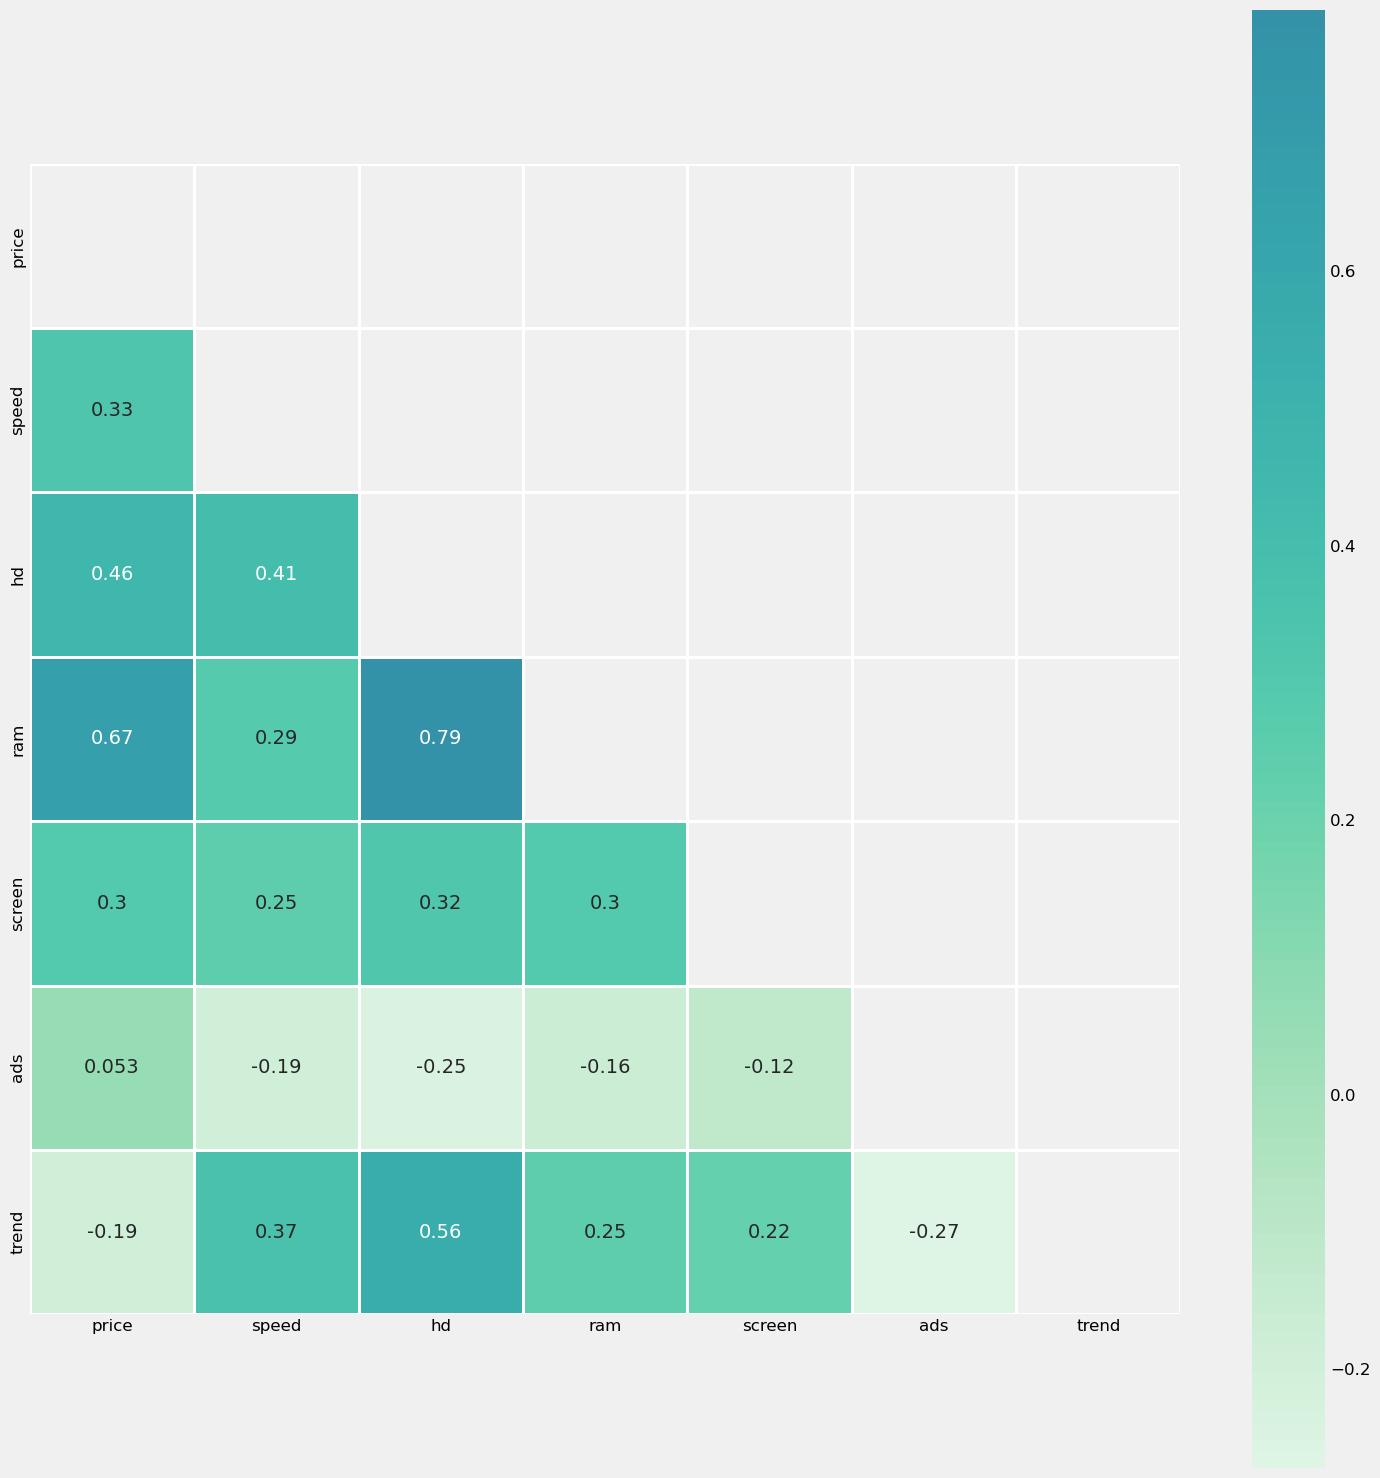

In [23]:
fig = plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(df_[col_num].corr(method='spearman'), dtype=bool))
sns.heatmap( df_[col_num].corr(method='spearman'), 
            cmap='mako_r', 
            center=True, 
            annot=True, 
            fmt='.2g', 
            mask = mask,
            linewidths=1, linecolor='white', square=True)
plt.show()

### Bonus
If we would like to examine only the correlation values between the independent variables & dependent variable, we could do it like so:

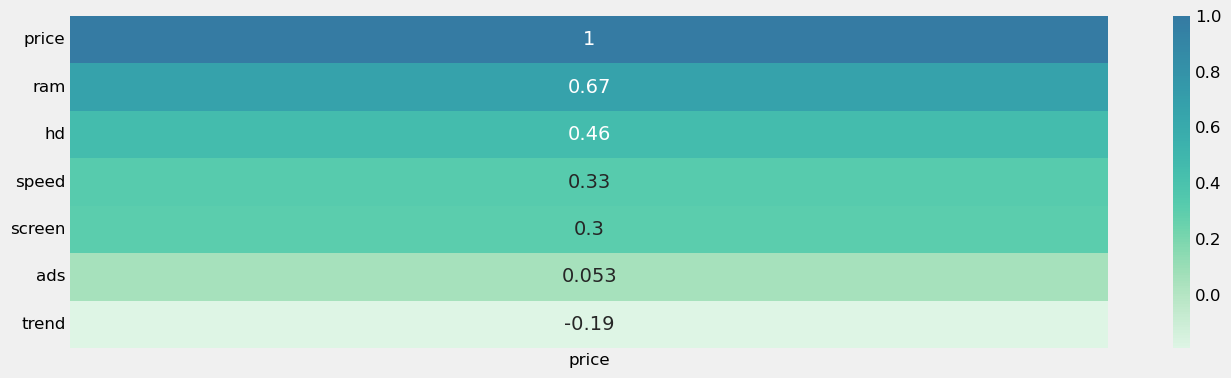

In [24]:
heatmap = sns.heatmap(
    df_[col_num].corr(method='spearman')[['price']].sort_values(
        by='price', ascending=False), center=True, annot=True, cmap='mako_r')

We try building a model without `ads`, `trend` (i.e. corr value lower than 0.3).

In [25]:
input_frame = df_.drop(['ads', 'trend'],axis=1).copy()
# evaluate the model
stats_score = evaluateModel(input_frame)
# record baseline score
collectScores(stats_score, 'stats')

model rmse: 412.66


<a id='5'></a>
### Feature Selection - eliminate Low variance features
Eliminate features with low / zero variance (i.e. features with same values or large proportion of same values with few unique values). In particular, low variance features may arise from dummy variables of categorical features with few members - dummy variable mostly 0s with few 1s. 

For our dataset, it does not appear to be the case, but let's apply it for practice.

In [26]:
# get a copy of the prepared dataset
X_ = df_.iloc[:,1:].copy()
X_

,speed,hd,ram,screen,ads,trend,cd_enc,multi_enc,premium_enc
1,25,80,4,14,94,1,0,0,1
2,33,85,2,14,94,1,0,0,1
3,25,170,4,15,94,1,0,0,1
4,25,170,8,14,94,1,0,0,0
5,33,340,16,14,94,1,0,0,1
...,...,...,...,...,...,...,...,...,...
6255,100,528,8,15,39,35,0,0,1
6256,66,850,16,15,39,35,1,1,1
6257,100,1200,24,15,39,35,1,0,1
6258,100,850,16,15,39,35,1,0,1


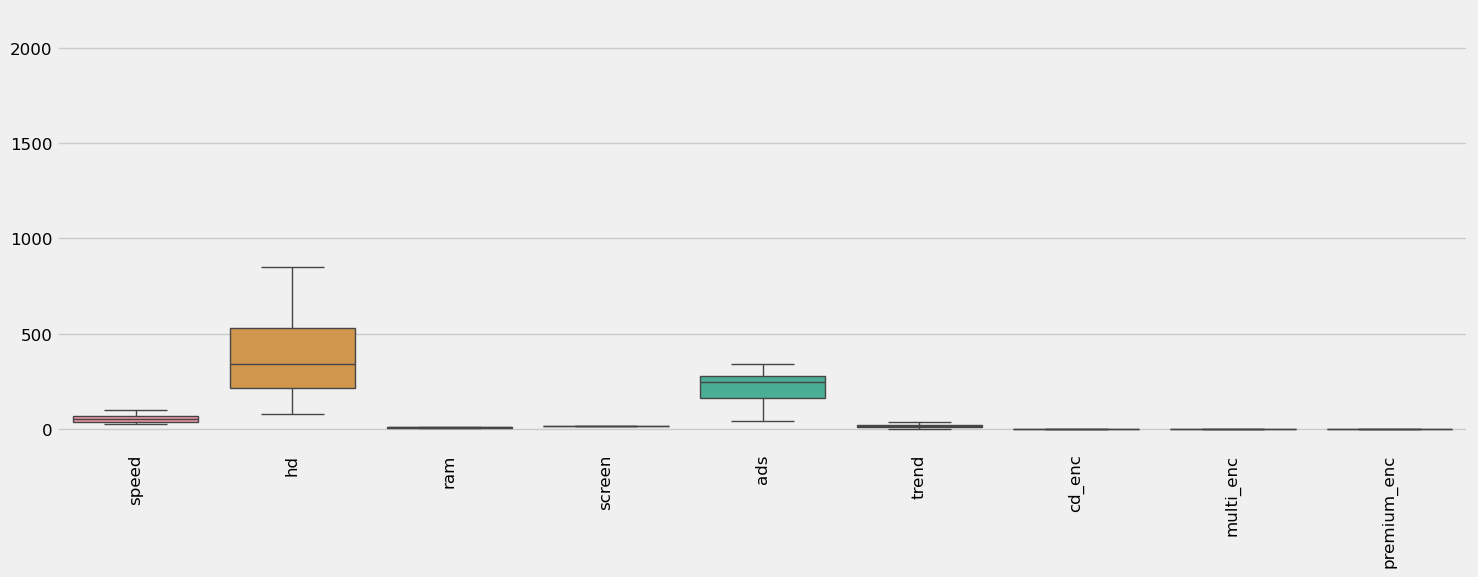

In [30]:
#visualize variances of variables
fig = plt.figure(figsize=(15,6))
sns.boxplot( data=X_ , fliersize=0, linewidth=1)
plt.xticks(rotation=90, )
plt.show()

Recall that the scale of the numerical columns are different to each other. variances are not on same scale, as visualized in boxplot below.
We should first normalize the data by dividing them with their mean. The normalization ensures all variances are on the same scale.

In [197]:
# Normalization to ensure all variances are on the same scale
normalized_X_ = X_/X_.mean()
normalized_X_.var()

speed          0.165481
hd             0.385161
ram            0.461740
screen         0.003839
ads            0.114353
trend          0.244412
cd_enc         1.152523
multi_enc      6.170516
premium_enc    0.108393
dtype: float64

In [198]:
# Fit transform on feature normalised_X, with lower threshold value
threshold_value = 0.1
vt = VarianceThreshold(threshold_value)
fea_vt = vt.fit_transform(normalized_X_)

# Get the support and shape of transformed features
print( vt.get_support() )
print( fea_vt.shape)

[ True  True  True False  True  True  True  True  True]
(6259, 8)


In [199]:
# the support functions as a mask
vt_mask = vt.get_support()
X_vt = X_.loc[:,vt_mask]

# which col got dropped?
[col for col in X_.columns if col not in X_vt.columns]

['screen']

We try building a model without `screen`


In [245]:
input_frame = df_.drop(['screen'],axis=1).copy()
noLowVariance_score = evaluateModel(input_frame)
# record baseline score
collectScores(noLowVariance_score, 'noLowVariance')

model rmse: 294.63


<a id='6'></a>
### Recursive Feature Elimination
Use DecisionTreeRegressor to help select features. Say we want to select top 5 features.

In [211]:

dtr = DecisionTreeRegressor(random_state=0)
rfe = RFE(dtr, n_features_to_select=5)
rfe.fit(X_vt, y)

RFE(estimator=DecisionTreeRegressor(random_state=0), n_features_to_select=5)

In [212]:
print('num_fea: %d' % rfe.n_features_)
print('fea mask: %s' % rfe.support_)
print('fea rank: %s' % rfe.ranking_)
selected_fea = ', '.join(map(str,X_vt.columns[rfe.support_]))
print('selected features: %s' % selected_fea )

num_fea: 5
fea mask: [ True  True  True False  True False False  True]
fea rank: [1 1 1 3 1 2 4 1]
selected features: speed, hd, ram, trend, premium_enc


We try building a model with `speed`, `hd`, `ram`, `trend`, `premium_enc`

In [222]:
df_[['speed', 'hd', 'ram', 'trend', 'premium_enc']]

,speed,hd,ram,trend,premium_enc
1,25,80,4,1,1
2,33,85,2,1,1
3,25,170,4,1,1
4,25,170,8,1,0
5,33,340,16,1,1
...,...,...,...,...,...
6255,100,528,8,35,1
6256,66,850,16,35,1
6257,100,1200,24,35,1
6258,100,850,16,35,1


In [247]:
input_frame = df_[['price','speed', 'hd', 'ram', 'trend', 'premium_enc']].copy()
rfe_score = evaluateModel(input_frame)
# record baseline score
collectScores(rfe_score, 'rfe')

model rmse: 303.68


<a id='7'></a>
### Recursive Feature Elimination with Cross Validation
Unless one has a specified number of features to use, we could do better by removing the randomness in terms of the specifiying the number of features to select upfront, and let the algorithm do the work for us.

In [232]:
folds = KFold(n_splits=10, shuffle=True, random_state=0)
dtr = DecisionTreeRegressor(random_state=0)

rfecv = RFECV(estimator=dtr, 
              cv=folds,
              scoring='neg_root_mean_squared_error')
rfecv.fit(X_vt, y)

RFECV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
      estimator=DecisionTreeRegressor(random_state=0),
      scoring='neg_root_mean_squared_error')

In [233]:
print('num_fea: %d' % rfecv.n_features_)
print('fea mask: %s' % rfecv.support_)
print('fea rank: %s' % rfecv.ranking_)
selected_fea = ', '.join(map(str,X_vt.columns[rfecv.support_]))
print('selected features: %s' % selected_fea )

num_fea: 8
fea mask: [ True  True  True  True  True  True  True  True]
fea rank: [1 1 1 1 1 1 1 1]
selected features: speed, hd, ram, ads, trend, cd_enc, multi_enc, premium_enc


`screen` feature eliminated. Similar outcome as when we eliminate features with low variance.

In [248]:
input_frame = df_[['price','speed', 'hd', 'ram', 'ads',
                   'trend', 'cd_enc', 'multi_enc', 'premium_enc']].copy()
rfecv_score = evaluateModel(input_frame)
# record baseline score
collectScores(rfecv_score, 'rfecv')

model rmse: 294.63


In [249]:
models

['baseline', 'stats', 'noLowVariance', 'rfe', 'rfecv']

<a id='8'></a>
### Mutual Information
Mutual information (MI) measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships. MI between two variables is a measure of the extent to which knowledge of one quantity reduces uncertainty (i.e. entropy) about the other. The least possible mutual information between variables is zero; they are independent.

In [258]:
def make_mi_scores(X, y, ):
    mi_scores = mutual_info_regression(X, y, )
    mi_scores=pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

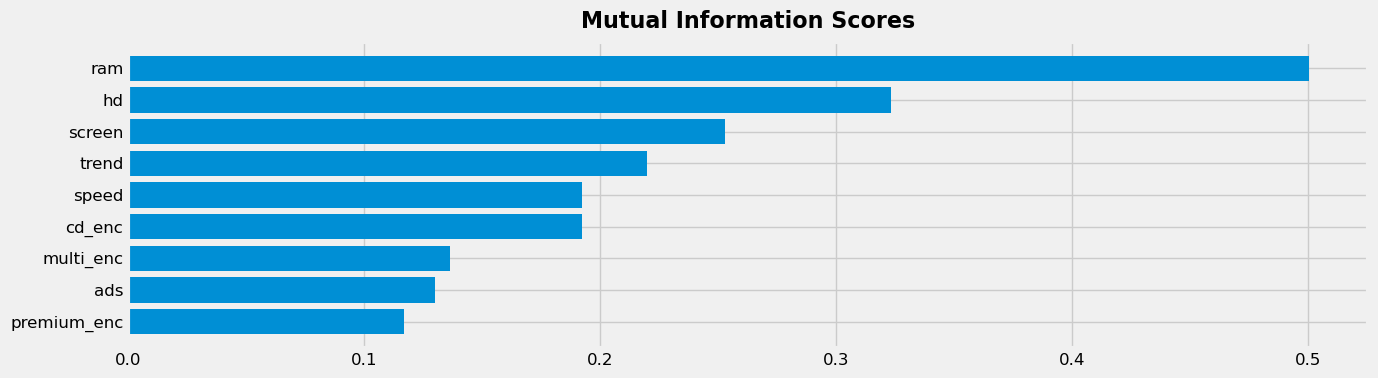

In [259]:
mi_scores = make_mi_scores(X_, y, )
plot_mi_scores(mi_scores)

`premium_enc` has a low MI score. It is really unimportant? Let's visualize it.

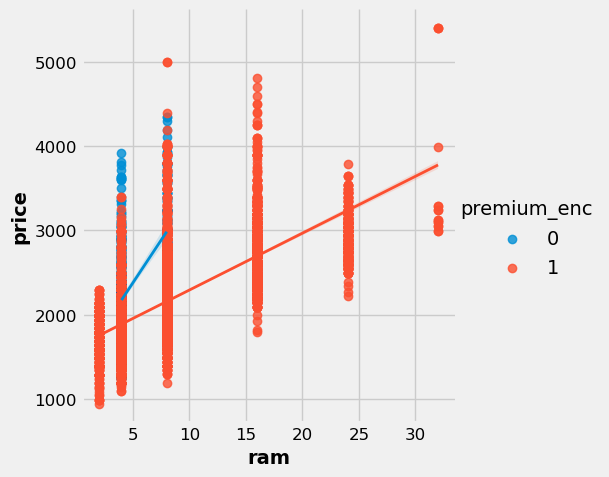

In [265]:
sns.lmplot(x='ram', y='price', hue='premium_enc',
           data=df_, line_kws={"lw":2})
plt.show()

As seen, `premium_enc` has an interaction effect that is important -- it segregates the `ram` into two groups. Each group has a distinct price range.

Based on this, if we decide to use all the variables-

In [267]:
input_frame = df_.copy()
all_score = evaluateModel(input_frame)
# record model score
collectScores(all_score, 'MI(all)')

model rmse: 274.88


<a id='9'></a>
### Regularized Regression 
We explore both Ridge, Lasso and ElasticNet regression in this section.

On model metrics, we'll use Root Mean Squared Error (RMSE)

In [271]:
X = df_.copy()
y = X.pop('price')

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=0)

In [274]:
# scale
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

#### Ridge Regression
Ridge penalizes sum of squared coefficients (L2 penalty); it reduces the coefficients of less useful variables to a small value, but not zero.

In [281]:
# optimal alpha for ridge regression
ridge_alphas = np.logspace(0,5,200)

opt_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
opt_ridge.fit(X_train_sc, y_train)
print(f"optimal ridge alpha: {opt_ridge.alpha_}")

# cross validate R2 of the Ridge regression w optimal alpha
ridge = Ridge(alpha=opt_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv=10)
print(f"Avg ridge scores: {ridge_scores.mean():.6f}")

optimal ridge alpha: 8.026433522257175
Avg ridge scores: 0.771072


#### Lasso Regression
Lasso deals primarily with the feature selection of valuable variables, eliminating ones that are not useful. It penalizes the sum of absolute values of the coefficients (L1 penalty) This also takes care of multicollinearity by choosing the "best" of the correlated variables and zeroing-out the other redundant ones.

In [282]:
opt_lasso = LassoCV(n_alphas=500, cv=10)
opt_lasso.fit(X_train_sc, y_train)
print(f"optimal lasso alpha: {opt_lasso.alpha_}")

# cross validate R2 of the Ridge regression w optimal alpha
lasso = Lasso(alpha=opt_lasso.alpha_)

lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=10)
print(f"Avg lasso scores: {lasso_scores.mean():.6f}")

optimal lasso alpha: 0.3610693976523501
Avg lasso scores: 0.771070


#### ElasticNet
Elastic net linearly combines the L1 & L2 penalties of the lasso and ridge methods.

In [283]:
l1_ratios = np.linspace(0.01, 1.0, 25)
opt_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10)
opt_enet.fit(X_train_sc, y_train)

print(f"optimal ent alpha: {opt_enet.alpha_}")
print(f"optimal ent alpha: {opt_enet.l1_ratio_}")

# cross-validate R2 of ElasticNet regression w optimal values
enet = ElasticNet(alpha=opt_enet.alpha_, l1_ratio=opt_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train_sc, y_train, cv=10)
print(f"Avg enet scores: {enet_scores.mean():.6f}")

optimal ent alpha: 0.3610693976523501
optimal ent alpha: 1.0
Avg enet scores: 0.771070


Ridge CV seems to be doing the best. Let's move forward with the model. Since fitted ridge using cross_val_Score, need to fit it outside to extract the coefficients


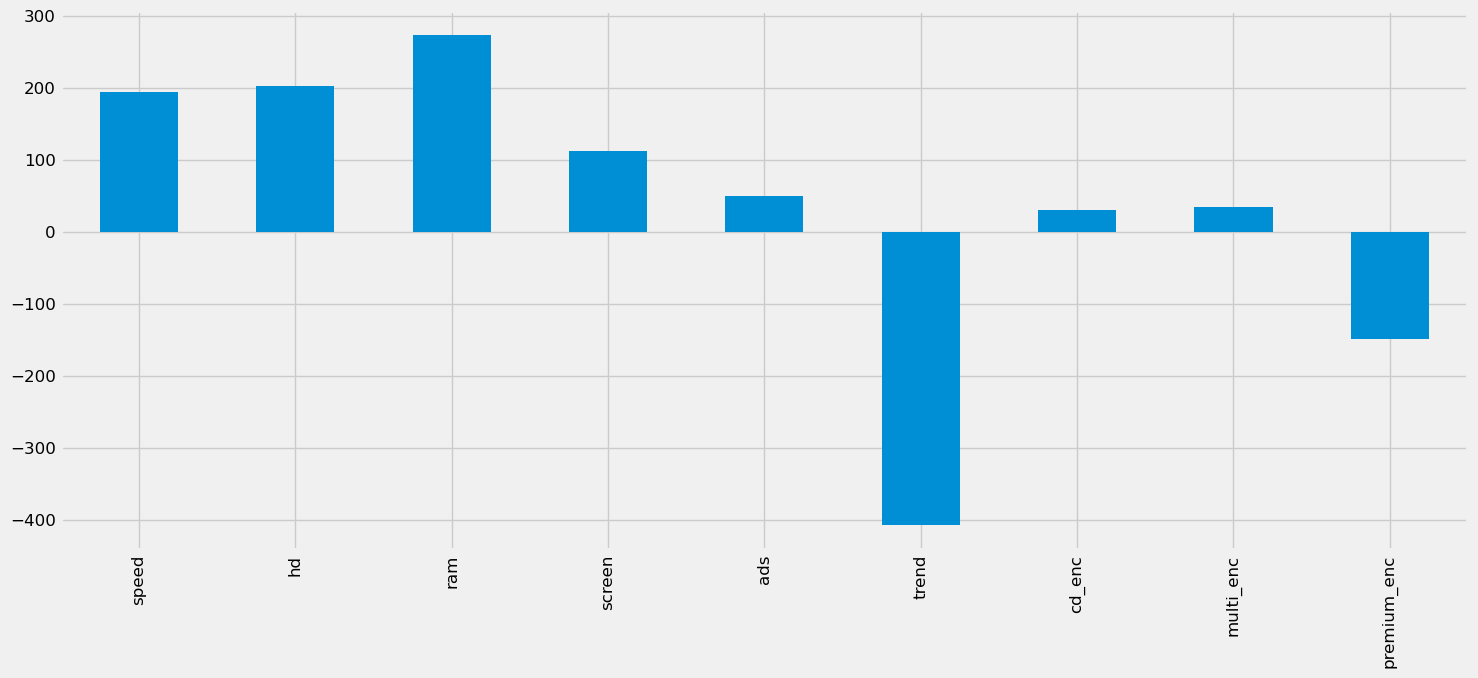

In [284]:
ridge.fit(X_train_sc, y_train)
features = [col for col in X]
pd.Series(ridge.coef_, index=features).plot.bar(figsize=(15, 7));

In [286]:
# evaluate model
ridge_pred = ridge.predict(X_test_sc)
ridge_score = mean_squared_error(y_test, ridge_pred, squared=False)
print(f'model rmse {ridge_score:.2f}')

model rmse 274.92


In [287]:
# record model score
collectScores(ridge_score, 'ridge')

You'll see that the features coincide with the usage of all the variables (I was surprised initially, but from the EDA and insights gleaned along the way, it makes sense) simply due to the nature of the dataset. It does not mean that regularized regression is not effective.


<a id='10'></a>
### Variance Inflation Factor & Interaction Term(s)
The process of feature selection and feature elimination are to mitigate building an overly complex model, and also to mitigate multi-colinearity. multi-collinearity can mask the importance of respective variable contribution to the target variable.

One way to identify multi-collinearity is through the use of the variance inflation factor (VIF). VIF indicates the percentage of the variance inflated for each variable's coefficient. Beginning at value of 1 (no collinearity), a VIF between 1-5 indicates moderate collinearity while values above 5 indicates high collinearity. Some cases where high VIF is fine includes the use of interaction terms, polynomial terms, or dummy variables (nominal variables with three or more categories).

* VIF starts at 1 and has no upper limit
* VIF = 1, no correlation between the independent variable and the other variables
* VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

We know from prior EDA that `hd` and `ram` are corelated, and so is `hd` and `trend` from the spearman correlation heatmap. The relationship makes sense; `HD` and `RAM` upgrades usually go hand in hand, but at an increased in cost. `HD` increases with trend. 
So we shall drop these variables, and create a new interaction terms (`hd` * `ram`) & (`hd` * `trend`) in their place.

In [301]:
def vif(frame, colName):
    vif_ = pd.Series([variance_inflation_factor(frame.values, i) for i in range(frame.shape[1])], 
                     index=frame.columns,
                     name=colName)
    return(vif_)

vif_full = vif(X, 'vif_full')
vif_full

speed           8.912021
hd             15.125046
ram             9.409406
screen         36.282936
ads            10.969552
trend          10.245682
cd_enc          3.442845
multi_enc       1.497608
premium_enc    10.763429
Name: vif_full, dtype: float64

In this last section, we create interaction terms and check its effect on the model performance.

In [312]:
# interaction terms
X['hd_ram'] = X['hd']*X['ram']
X['hd_trend'] = X['hd']*X['trend']

In [313]:
# drop redundant cols
X_its = X.drop(['hd', 'ram', 'screen', 'trend'], axis=1).copy()

In [314]:
vif_X_its = vif(X_its, 'vif_X_its')
vif_update = pd.concat([vif_full, vif_X_its], axis=1)
vif_update

,vif_full,vif_X_its
speed,8.912021,7.732583
hd,15.125046,NaN
ram,9.409406,NaN
screen,36.282936,NaN
ads,10.969552,6.034924
trend,10.245682,NaN
cd_enc,3.442845,3.226254
multi_enc,1.497608,1.475701
premium_enc,10.763429,7.401294
hd_ram,NaN,4.725424


In [323]:
vif_intTerms_score = evaluateModel(df_)
# record baseline score
collectScores(vif_intTerms_score, 'vif_intTerms')

model rmse: 274.88


In [329]:
pd.DataFrame(list(zip(models,scores)), columns=['model','rmse'])

,model,rmse
0,baseline,467.292442
1,stats,412.657613
2,noLowVariance,294.632174
3,rfe,303.679030
4,rfecv,294.632174
5,MI(all),274.876673
6,ridge,274.918534
7,vif_intTerms,274.876673


<a id='11'></a>
#### Conclusion

Interesting to note that for this dataset, it appears that most variables are useful in predicting computer price. In particular, the performance of models no.5 (used all variables) and no.7 (dropped `screen`, introduced two interaction terms (`hd` * `ram`) & (`hd` * `trend`) are tied (and relatively the best among the models created).
Personally, wasn't expecting this, but is a rather pleasant surprise.

An awareness of the techniques and methods available expands the range of possible tools in the toolbox to use. An understanding of the data towards feature engineering goes a long way in modeling. While multicollinearity still exists for model no.7, the extent is not as severe as model no. 5.

That's it for now, Hope you had a pleasant read. See you next article. 😀



